In [106]:
# Import required libraries
import scipy.io as sio
import numpy as np
import datetime
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import math as m
import gsw
import matplotlib as mpl
import cmcrameri as ccm
from scipy.interpolate import interp1d, interp2d, griddata
import scipy.signal as signal
from IPython.display import display, HTML
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import cmocean as cmo
import warnings
from pytides2.tide import Tide

# Ignore warnings
warnings.filterwarnings("ignore")

# Set the path for the src directory for importing custom modules
import sys
import os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))

# Import custom modules
from paths import *
from functions import *


In [110]:
figpath

PosixPath('/Users/annek/Library/CloudStorage/OneDrive-SharedLibraries-NIOZ/PhD Anneke Vries - General/Vries_2025_Hydrography_Circulation_NK/outputs')

# Functions

In [2]:
def format_xaxes_time(ax, type ='Auto'):
    if type == 'Auto':
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.set_xlabel('')
    elif type == 'AutoMonth':
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
        ax.set_xlabel('')     
        #minor ticks
        ax.xaxis.set_minor_locator(mdates.MonthLocator())  

def remove_spines(ax, spines_to_keep=['bottom', 'left']):
    """Remove spines from a matplotlib axis obj
    Parameters
    ----------
    ax : matplotlib axis object
    spines_to_keep : list of strings
        List of spines to keep on the axis
    """
    spines_to_drop = [spine for spine in ax.spines if spine not in spines_to_keep]
    for spine in spines_to_drop:
        ax.spines[spine].set_visible(False)
    

# Import data

## Velocity ADCP import

In [3]:
from velocity_preprocessing_functions import *

ds_velo_300, _, df_cons300, my_tide_along, _, _, _, _, _, ds_velo_no_outlier_removal_300 = open_and_proces_mat_adcp(f300)
ds_velo_75, _, df_cons75, _, _, _, _, _, _, ds_velo_no_outlier_removal_75 = open_and_proces_mat_adcp(f75)
print("Total amplitude tide : ", df_cons75['Velocity amplitude [mm/s]'].sum().round(2))



Total amplitude tide :  23.68


### Combining Velocity files

In [4]:
non_overlapping_z = np.concatenate([ds_velo_75.z[(ds_velo_75.z > ds_velo_300.z.max())].to_numpy(), ds_velo_300.z.to_numpy()])

In [5]:
df_velo_both_ori = xr.merge([ds_velo_300, ds_velo_75], join='outer')
df_velo_both = df_velo_both_ori.sel(z = non_overlapping_z)
df_velo_outliers = xr.merge([ds_velo_no_outlier_removal_300, ds_velo_no_outlier_removal_75], join='outer')

# combine every half hour
df_velo_both_high_freq = xr.merge(
    [ds_velo_300.interp(time=pd.date_range((ds_velo_75.time[0]).values, (ds_velo_75.time[-1]).values, freq='0.5H')),
    ds_velo_75.interp(time=pd.date_range((ds_velo_75.time[0]).values, (ds_velo_75.time[-1]).values, freq='0.5H'))]).sel(z = non_overlapping_z)



## Mooring and ctd data - import

In [6]:
df_monthly = pd.read_csv(file_monthly_CTD, index_col=0, parse_dates=["date"])
df_monthly["datedate"] = df_monthly.date.copy()
df_monthly['datetime'] = pd.to_timedelta(df_monthly.time-1, unit='D') + pd.to_datetime(pd.to_datetime(df_monthly.datedate).dt.year, format='%Y')
df_monthly.date = df_monthly.datetime.copy()

df_gf10 = df_monthly[(df_monthly['St.']=="GF10")]#&(df_monthly['Type']=='CTD')]
df_mooring = pd.read_csv(file_mooring_microcat, index_col=0, parse_dates=True)

var ='temp'
df10piv = df_gf10.drop_duplicates(['date', 'Pressure [dbar]']).pivot('date', 'Pressure [dbar]', var)
X =df10piv.index.values
Y = df10piv.columns.values
Xpiv, Ypiv = np.meshgrid(df10piv.index.values, df10piv.columns.values)
Z=df10piv.values.T



df_mooring['Mean_pressure'] = df_mooring.groupby('depth').transform('mean')['Pressure [dbar]'].round(2)
df_gf10['datetime_first'] = df_gf10.groupby('Name').transform('first')['datetime']


# calculate mean pressure per depth for df_mooring
df_mooring['Mean_pressure'] = df_mooring.groupby('depth').transform('mean')['Pressure [dbar]'].round(2)
df_gf10['datetime_first'] = df_gf10.groupby('Name').transform('first')['datetime']

df_mooring['date'] = df_mooring.date.astype('datetime64[m]')
df_gf10.date = df_gf10.date.astype('datetime64[m]')

### Combining mooring and cast

In [7]:

                                                  
df_ctd_moor = pd.concat([
    df_gf10.rename(columns={"date":"actual_date","datetime_first":"date",}).set_index(['Pressure [dbar]', 'date']), 
    df_mooring.rename(columns={"Mean_pressure":'Pressure [dbar]', 'Pressure [dbar]': 'Pres_ori'}).set_index(['Pressure [dbar]', 'date'])
    ])

# rename index in df_ctd_moor
df_ctd_moor = df_ctd_moor.rename_axis(index={'Pressure [dbar]': 'z', 'date': 'time'})

df_ctd_moor['SA'] = gsw.SA_from_SP(df_ctd_moor['sal'].values, df_ctd_moor['Pres_ori'].values, lon=-51, lat=64)
df_ctd_moor['CT'] = gsw.CT_from_t(df_ctd_moor['SA'].values, df_ctd_moor['temp'].values, df_ctd_moor['Pres_ori'].values)

da_temp = xr.DataArray.from_series(df_ctd_moor['temp'])
ds_ctd_moor = xr.Dataset.from_dataframe(df_ctd_moor[['temp', 'sal', 'dens']])
df_original_points = df_ctd_moor.rename(columns={'time':'timetime'}).reset_index()
df_ctd_moor = df_ctd_moor.rename(columns={'time':'ttttime'}).reset_index()
df_ctd_moor.loc[df_ctd_moor.Pres_ori.isna(),'Pres_ori'] = df_ctd_moor[df_ctd_moor.Pres_ori.isna()].z.copy()


## Define time array and zarray

- make a grid of all depths of velocity and all times of mooring and ctd
- multiply for heat flux
- compare that to mean per day and mean per 10 m 

In [8]:
zvals = df_velo_both.z.to_numpy()
# zvals
timevals = df_mooring[df_mooring.depth == 540].date.to_numpy()
start_date_mooring = df_mooring[df_mooring.depth == 540].date.iloc[0]

# ds_ctd_moor time dimesion in seconds 
# time_seconds = pd.to_timedelta(ds_ctd_moor.time - ds_ctd_moor.time[0], unit='s').total_seconds().to_numpy()
time_seconds = (df_mooring.date - start_date_mooring).dt.total_seconds()
time_hours =  time_seconds/3600
time_days = time_hours/24
time_datetime  = ds_ctd_moor.time.values

time_seconds_ctd = (df_gf10.date - start_date_mooring).dt.total_seconds()
time_seconds_moor = (df_mooring.date - start_date_mooring).dt.total_seconds()


## Grid temperature 

In [9]:
ds_gridded_tem_sal = xr.Dataset()

var = 'temp'
scaley = 10 # m
scalex = 30*24*3600 # 30 days

vars = ['temp', 'sal', 'dens', 'SA', 'CT']

def interpolate_data_2D(var, df_original_points, time_array_seconds, z_array_meters, scaley=10, scalex=30*24*3600):
    '''
    Interpolate data to a 2D grid
    var : variable to interpolate
    df_original_points : dataframe with original data, needs to have columns 'time', 'z', 'Pres_ori'
    scaley : scale for y axis in m
    scalex : scale for x axis in seconds, to give a certain weight to the time dimension vs the depth dimension
    returns : DataArray of interpolated data on a 2D grid
    '''
    units = dict(zip(['temp', 'sal', 'dens', 'SA', 'CT'],   ['°C', 'psu', 'kg/m^3', 'g/kg', '°C']))

    df_original_points = df_original_points.set_index('time', 'z').sort_index().reset_index()
    df_original_points.sort_index(inplace=True)


    valid_indices = ~np.isnan(df_original_points[var].to_numpy())
    points = (    (df_original_points.time - start_date_mooring).dt.total_seconds().to_numpy()[valid_indices]/scalex
    , df_original_points['Pres_ori'].to_numpy()[valid_indices]/scaley
    )

    values = df_original_points[var].to_numpy()[valid_indices]
    xi = np.unique(time_array_seconds/scalex)   # to be projected on
    yi = z_array_meters/scaley
    zi = griddata(points, values, (xi[None, :], yi[:, None]), method='linear')

    da_gridded_tem_sal= xr.DataArray(zi, dims=['z', 'time'], coords={'z':zvals, 
                                                                'time':(start_date_mooring  +pd.to_timedelta(xi*scalex, unit='s'))
                                                                }, 
                                                name=f'{var}',  
                                                 attrs={'units':f'{units[var]}', 'interpolation':'linear', 'interpolation_scalex[D]':scalex/86400, 'interpolation_scaley[m]':scaley})
    return da_gridded_tem_sal


for var in vars:
    scalex = 30*24*3600 # 30 days
    da = interpolate_data_2D(var, df_ctd_moor, time_seconds, zvals, scalex=scalex)
    ds_gridded_tem_sal[f"{var}"] = da



# Calculate Heat flux

$ Q = c_p*m*\Delta T$ 

$ Q = c_p*\rho*v*w*h*\Delta T$ 


$c_p$ = specific heat capacity of water [J/(kg/K)]

$m$ = mass [kg]

$\Delta T$ = Temperature increase [K]

$\rho$ = density of water [kg/m3]

$ w, h$ approximate width and height [m]

## Define parameters

In [10]:
L = 3.34e5 # J/kg # latent heat of fusion
cp_ice = 2090 # J/(kg K) # specific heat of ice
dens_ice = 917 # kg/m3 # density of ice
p = 300 # db  
dens_water = 1028 # kg/m3
lat = 64.6031
lon = -50.987283
SA = gsw.SA_from_SP(33.25,p, lon, lat)
T = 1.6

cp_water = gsw.cp_t_exact(SA,T,p) # J/(kg K)
T_freezing = gsw.t_freezing(SA,p,0)
print(cp_water, T_freezing)

Average_width_fjord = 5400 #m



3986.9410094681107 -2.0452518563063626


Calculate parameters that vary

In [11]:
# calculate T_freezing
ds_gridded_tem_sal['T_freezing'] = gsw.t_freezing(ds_gridded_tem_sal.SA, ds_gridded_tem_sal.z, 0)
# calculate relative temperature
ds_gridded_tem_sal['rel_temp'] = ds_gridded_tem_sal.CT - ds_gridded_tem_sal.T_freezing
# calculate heat capacity
ds_gridded_tem_sal['cp_water'] = gsw.cp_t_exact(ds_gridded_tem_sal.SA, ds_gridded_tem_sal.CT, ds_gridded_tem_sal.z)

### Parameter sensitivity
Checking whether the outcome is sensitive to density or chosen T and S

### weights

In [12]:
weights = zvals[1:]-zvals[:-1]
weights = np.append(weights[0], weights)
da_z = df_velo_both_high_freq.z
weights = xr.DataArray(weights,
     dims=['z'], coords={'z':da_z})

## Calculating heat flux in 2d 

In [13]:
ds_heat_flux= xr.Dataset(attrs={'Description': 'Heat fluxes calculated', 'units': 'W/m2'})
ds_heat_flux['2d'] = ds_gridded_tem_sal['rel_temp'] *df_velo_both_high_freq.Alongmmpersec*ds_gridded_tem_sal['cp_water']*ds_gridded_tem_sal['dens'] /1000 # mm/s to m/s    # in W/m2
ds_heat_flux['2d_residual'] = ds_gridded_tem_sal['rel_temp'] *df_velo_both_high_freq.Along_res*ds_gridded_tem_sal['cp_water']*ds_gridded_tem_sal['dens'] /1000 # mm/s to m/s
ds_heat_flux['2d_weighted'] = ds_heat_flux['2d'].weighted(weights)

# calculate the temporal difference in temperature compared to the step before
ds_gridded_tem_sal['rel_temp_diff'] = ds_gridded_tem_sal['rel_temp'] - ds_gridded_tem_sal['rel_temp'].shift(time=1)
ds_heat_flux['2d_rel_temp_increase'] = ds_gridded_tem_sal['rel_temp_diff'] *df_velo_both_high_freq.Alongmmpersec*cp_water*dens_water /1000 # mm/s to m/s
ds_heat_flux = ds_heat_flux.resample(time='1H').nearest(tolerance='5min')

### Heat flux per depth bin

In [14]:
# mooring_t = ((da_temp_like_velo - ds_gridded_tem_sal['rel_temp'].shift(time=1))  *df_velo_both_high_freq.Alongmmpersec*cp_water*dens_water /1000 ).sel(z = slice( 550,50))

mooring_t = ds_heat_flux['2d'].sel(z = slice( 550, 50)).rename('heat_flux')
mooring_t_100m = mooring_t.groupby_bins('z', bins=range(50, 600, 100)).mean() *100 *Average_width_fjord /1e9 # GW 
mooring_t_sum =( mooring_t.mean('z').resample(time='1W').mean() *500 *Average_width_fjord /1e9 ).to_series().reset_index().rename(columns={ 0: 'heat_flux'})
# weekly resample mean and export to series
df_mooring_t_bins = mooring_t_100m.resample(time='1W').mean().to_series().reset_index().rename(columns={ 0: 'heat_flux'})
# zbins as type string
df_mooring_t_bins['z_bins'] = df_mooring_t_bins['z_bins'].astype(str)




Assuming a width of 5.4 km ( sentinel  hub)



# Decomposing into components per tide

Following Diez2013

Width of the fjord from sentinel 

In [15]:
# import slack tides
file_slack_tides = "../data/processed/positive_slack_tide_moments.csv"
df_slack_tides = pd.read_csv(file_slack_tides, index_col=None)
df_slack_tides['time'] = pd.to_datetime(df_slack_tides['time'], format='%d/%m/%Y %H:%M')
slack_tides = df_slack_tides['time'].to_numpy().flatten()


In [16]:
print(f'Average_width_fjord: {Average_width_fjord}') # via sentinel


Average_width_fjord: 5400


In [17]:
# select mooring 540
df_mooring_540 = df_mooring[df_mooring.depth == 540]
df_mooring_540 = df_mooring_540.drop(columns=['time']).rename(columns={'date':'time'}).set_index(['time'])
df_mooring_540['eta'] = ((gsw.z_from_p(df_mooring_540['Pressure [dbar]'].values, lat=64) - gsw.z_from_p(df_mooring_540['Mean_pressure'].values, lat=64)) *-1)
ds_eta = df_mooring_540['eta'].to_xarray()

ds_gridded_tem_sal['eta'] = ds_gridded_tem_sal.temp.copy(deep=True)
ds_gridded_tem_sal['eta'] = np.nan
ds_gridded_tem_sal['eta'] = ds_eta


In [18]:
ds_heat_transport_combined = xr.Dataset(coords={'z_range': ["empty"]})

def bar(ds, i):
    ''' Calculates mean per tidal interval,'''
    return ds.sel(time=slice(tide_cutoffs[i], tide_cutoffs[i+1]-pd.to_timedelta('0.5H'))).mean(dim='time')  
def time_slice(ds, i):
    return ds.sel(time=slice(tide_cutoffs[i], tide_cutoffs[i+1]-pd.to_timedelta('0.5H')))  # to correct for slice that takes into account the first hour of the next tide

tide_cutoffs = slack_tides

ds_heat_transport= xr.DataArray(coords={'time': tide_cutoffs}, dims=['time'], name='2d').to_dataset()
for new_var in ['T1', 'T4', 'T6', 'T7', 'T2']:
    ds_heat_transport[new_var] = ds_heat_transport['2d'].copy(deep=True)
ds_heat_transport = ds_heat_transport.drop_vars('2d')

ds_heat_transport_calc= xr.DataArray(coords={'time': tide_cutoffs}, dims=['time'], name='2d').to_dataset()
for extra_var in ['u_bar', 'u_bar_underscore', 'u_first_bar_than_underscore', 'theta_bar', 'theta_bar_underscore', 'u_tilde', 'u_tilde_underscore', 'theta_tilde', 'theta_tilde_underscore', 'u_v_bar', 'theta_v_bar', 'u_v_tilde', 'theta_v_tilde', 'u_v_max', 'u_tilde_underscore_max']:
    ds_heat_transport_calc[extra_var] = ds_heat_transport_calc['2d'].copy(deep=True)

z_ranges = [[5,150], [5,550], [5,50]]
for i, (upper_bound, lower_bound)  in enumerate(z_ranges):
    height = lower_bound-upper_bound
    h_bar = height*Average_width_fjord

    # theta is delta T times c- times rho
    constants = (ds_gridded_tem_sal['cp_water']*ds_gridded_tem_sal['dens']) # J/kg/K * kg/m3 = J/m3/K
    theta = (ds_gridded_tem_sal['rel_temp']*constants).sel(z=slice(lower_bound,upper_bound)).sortby('z') # delta T * c- * rho
    u = df_velo_both_high_freq.sel(z=slice(lower_bound,upper_bound)).Alongmmpersec.sortby('z')  /1000 # mm/s to m/s 
    eta = ds_gridded_tem_sal['eta']

    u_underscore = u.weighted(weights).mean(dim='z')
    theta_underscore = theta.weighted(weights).mean(dim='z')

    u_v = u - u_underscore
    theta_v = theta - theta_underscore

    for i in np.arange(len(np.array(tide_cutoffs))-1):
        u_bar_underscore = time_slice(u,i).weighted(weights).mean()
        u_first_bar_than_underscore = bar(u.sel(time=slice(tide_cutoffs[i], tide_cutoffs[i+1])),i).weighted(weights).mean(dim='z')

        theta_bar_underscore = time_slice(theta,i).weighted(weights).mean()

        u_bar = bar(u,i)
        theta_bar = bar(theta,i)

        u_tilde = u - u_bar
        theta_tilde = theta - theta_bar

        ds_heat_transport['T1'][dict(time=i)] = h_bar * u_bar_underscore * theta_bar_underscore # T1
        
        u_tilde_underscore = u_tilde.weighted(weights).mean(dim='z')
        theta_tilde_underscore = theta_tilde.weighted(weights).mean(dim='z') 

        ds_heat_transport['T4'][dict(time=i)] = h_bar * (u_tilde_underscore * theta_tilde_underscore).mean(dim='time') # T4

        u_v_bar = bar(u_v, i)
        theta_v_bar = bar(theta_v, i)

        ds_heat_transport['T7'][dict(time=i)] = h_bar * (u_v_bar * theta_v_bar).weighted(weights).mean(dim='z') # T7

        u_v_tilde = u_v - bar(u_v, i)
        theta_v_tilde = theta_v - bar(theta_v, i)

        ds_heat_transport['T6'][dict(time=i)] = h_bar * bar((u_v_tilde * theta_v_tilde),i).weighted(weights).mean(dim='z')  # T6

        eta_tilde = eta - bar(eta, i)
        T2 = bar((eta_tilde * u_tilde_underscore),i) * theta_bar_underscore
        ds_heat_transport['T2'][dict(time=i)] = T2

        # For looking closer into the calculation
        ds_heat_transport_calc['u_bar_underscore'][dict(time=i)] = u_bar_underscore
        ds_heat_transport_calc['u_first_bar_than_underscore'][dict(time=i)] = u_first_bar_than_underscore
        ds_heat_transport_calc['u_v_bar'][dict(time=i)] = u_v_bar.sel(z=530, method='nearest')
        ds_heat_transport_calc['theta_v_bar'][dict(time=i)] = theta_v_bar.sel(z=530, method='nearest')
        time_range = u_v.sel(time=slice(tide_cutoffs[i], tide_cutoffs[i+1]))
        if time_range.size > 0 and not np.all(np.isnan(time_range)):
            max_value = np.nanmax(abs(time_range))
            ds_heat_transport_calc['u_v_max'][dict(time=i)] = max_value
            ds_heat_transport_calc['u_tilde_underscore_max'][dict(time=i)] = np.nanmax(abs(u_tilde_underscore.sel(time=slice(tide_cutoffs[i], tide_cutoffs[i+1])).max()))
        else:
            print(tide_cutoffs[i])
        
    # multilpy by constants heat capaity and density and divide by 1e9 to get GW
    ds_heat_transport = ds_heat_transport /1e9 # GW

    # sum T1, T2, T4, T6, T7
    ds_heat_transport['total'] = ds_heat_transport['T1'] + ds_heat_transport['T2'] + ds_heat_transport['T4'] + ds_heat_transport['T6'] + ds_heat_transport['T7']

    # The dataset exists, and you can perform operations on it
    ds_heat_transport_combined = xr.concat([
        ds_heat_transport_combined, 
        ds_heat_transport.assign_coords(z_range=f'{upper_bound}-{lower_bound}')], dim='z_range')

ds_heat_transport_combined.drop_duplicates('z_range')

<xarray.Dataset>
Dimensions:  (z_range: 4, time: 731)
Coordinates:
  * z_range  (z_range) <U5 'empty' '5-150' '5-550' '5-50'
  * time     (time) datetime64[ns] 2018-05-30T05:00:00 ... 2019-06-11T22:59:00
Data variables:
    T1       (z_range, time) float64 nan nan nan nan ... -198.0 -116.4 nan
    T4       (z_range, time) float64 nan nan nan nan ... -19.84 2.463 15.0 nan
    T6       (z_range, time) float64 nan nan nan nan ... 0.02705 -0.01199 nan
    T7       (z_range, time) float64 nan nan nan nan ... -24.83 -19.53 nan
    T2       (z_range, time) float64 nan nan nan nan ... 0.0003363 0.0003603 nan
    total    (z_range, time) float64 nan nan nan nan ... -220.3 -120.9 nan

In [19]:
ds_heat_transport_combined.sel(z_range=['5-150', '5-550']).quantile([0.05, 0.95], dim='time').to_dataframe(dim_order=['z_range', 'quantile']).round(2).style.format("{:.2f}").background_gradient(cmap='PiYG')

In [100]:
# find average per month
df_heat_transport_monthly = ds_heat_transport_combined.sel(z_range=[ '5-150', '5-550']).resample(time='M').mean().to_dataframe(dim_order=['z_range', 'time']).round(0).loc[:,['total' ]]
overall_time_mean = ds_heat_transport_combined.sel(z_range=[ '5-150', '5-550']).mean('time').to_dataframe(dim_order=['z_range']).round(0).loc[:,['total' ]]
# add extra multiindex row with "yearly"
overall_time_mean.index = pd.MultiIndex.from_product([ overall_time_mean.index, ['overal_time_mean']])
# concat yearly mean to df_heat_transport_monthly
df_heat_transport_monthly = pd.concat([df_heat_transport_monthly, overall_time_mean], axis=0).sort_index()
# add  row with total
# add exra columm multi index

# add std yearly to df_heat_transport_monthly
overall_std = ds_heat_transport_combined.sel(z_range=[ '5-150', '5-550']).std('time').to_dataframe(dim_order=['z_range']).round(0).loc[:,['total' ]]
print(overall_std)
df_heat_transport_monthly.loc[['5-550'], :].style.format("{:.2f}").background_gradient(cmap='seismic')


         total
z_range       
5-150    329.0
5-550    415.0


In [101]:
ds_heat_transport_combined

<xarray.Dataset>
Dimensions:  (z_range: 4, time: 725)
Coordinates:
  * z_range  (z_range) <U5 'empty' '5-150' '5-550' '5-50'
  * time     (time) datetime64[ns] 2018-05-30T17:00:00 ... 2019-06-11T11:59:00
Data variables:
    T1       (z_range, time) float64 nan nan nan nan ... -310.0 -198.0 -116.4
    T4       (z_range, time) float64 nan nan nan nan ... -19.84 2.463 15.0
    T6       (z_range, time) float64 nan nan nan ... -0.0183 0.02705 -0.01199
    T7       (z_range, time) float64 nan nan nan nan ... -20.91 -24.83 -19.53
    T2       (z_range, time) float64 nan nan nan ... 0.0003363 0.0003603
    total    (z_range, time) float64 nan nan nan nan ... -350.7 -220.3 -120.9

In [103]:
yearly_mean

,,total
z_range,,
5-150,yearly,106.0
5-550,yearly,267.0


In [102]:
# find average per month
df_heat_transport_monthly = ds_heat_transport_combined.sel(z_range=[ '5-150', '5-550']).resample(time='M').mean().to_dataframe(dim_order=['z_range', 'time']).round(0).loc[:,['total' ]]
yearly_mean = ds_heat_transport_combined.sel(z_range=[ '5-150', '5-550']).sel(time=slice('2018-06-01', '2019-06-01')).mean('time').to_dataframe(dim_order=['z_range']).round(0).loc[:,['total' ]]
# add extra multiindex row with "yearly"
yearly_mean.index = pd.MultiIndex.from_product([ yearly_mean.index, ['yearly']])
# concat yearly mean to df_heat_transport_monthly
df_heat_transport_monthly = pd.concat([df_heat_transport_monthly, yearly_mean], axis=0).sort_index()
# add  row with total
# add exra columm multi index

# add std yearly to df_heat_transport_monthly
yearly_std = ds_heat_transport_combined.sel(z_range=[ '5-150', '5-550']).std('time').to_dataframe(dim_order=['z_range']).round(0).loc[:,['total' ]]
print(yearly_std)
df_heat_transport_monthly.loc[['5-550'], :].style.format("{:.2f}").background_gradient(cmap='seismic')


         total
z_range       
5-150    329.0
5-550    415.0


# epiodic inflow 1

In [31]:

print("Mean transport between 5-550 m depth: ", ds_heat_transport_combined.sel(time=slice(pd.to_datetime("2018-10-10"), pd.to_datetime("2018-11-13"))).mean(dim='time')['total'].sel(z_range='5-550').round(2))
print("Std transport between 5-550 m depth: ", ds_heat_transport_combined.sel(time=slice(pd.to_datetime("2018-10-10"), pd.to_datetime("2018-11-13"))).std(dim='time')['total'].sel(z_range='5-550').round(2))


Mean transport between 5-550 m depth:  <xarray.DataArray 'total' ()>
array(313.52)
Coordinates:
    z_range  <U5 '5-550'
Std transport between 5-550 m depth:  <xarray.DataArray 'total' ()>
array(393.36)
Coordinates:
    z_range  <U5 '5-550'


# during phase VI

In [32]:
# 'January 10, 2019', 'April 18, 2019',
# Calculate mean transport and std during dates above

print("Mean transport between 5-550 m depth: ", ds_heat_transport_combined.sel(time=slice(pd.to_datetime("2019-01-10"), pd.to_datetime("2019-04-18"))).mean(dim='time')['total'].sel(z_range='5-550').round(2))
print("Std transport between 5-550 m depth: ", ds_heat_transport_combined.sel(time=slice(pd.to_datetime("2019-01-10"), pd.to_datetime("2019-04-18"))).std(dim='time')['total'].sel(z_range='5-550').round(2))

# for 5-150 m depth
print("\nMean transport between 5-150 m depth: ", ds_heat_transport_combined.sel(time=slice(pd.to_datetime("2019-01-10"), pd.to_datetime("2019-04-18"))).mean(dim='time')['total'].sel(z_range='5-150').round(2))
print("Std transport between 5-150 m depth: ", ds_heat_transport_combined.sel(time=slice(pd.to_datetime("2019-01-10"), pd.to_datetime("2019-04-18"))).std(dim='time')['total'].sel(z_range='5-150').round(2))

Mean transport between 5-550 m depth:  <xarray.DataArray 'total' ()>
array(562.01)
Coordinates:
    z_range  <U5 '5-550'
Std transport between 5-550 m depth:  <xarray.DataArray 'total' ()>
array(365.1)
Coordinates:
    z_range  <U5 '5-550'

Mean transport between 5-150 m depth:  <xarray.DataArray 'total' ()>
array(127.98)
Coordinates:
    z_range  <U5 '5-150'
Std transport between 5-150 m depth:  <xarray.DataArray 'total' ()>
array(202.82)
Coordinates:
    z_range  <U5 '5-150'


### Standard deviation

In [33]:
# find average per month
df_heat_transport_monthly_std = ds_heat_transport_combined.sel(z_range=[ '5-150', '5-550']).resample(time='M').std().to_dataframe(dim_order=['z_range', 'time']).round(0).loc[:,['T1', 'T4','T7','total' ]]
df_heat_transport_monthly_std.style.format("{:.2f}").background_gradient(cmap='viridis')
yearly_std = ds_heat_transport_combined.sel(z_range=[ '5-150', '5-550']).std('time').to_dataframe(dim_order=['z_range']).round(0).loc[:,['T1', 'T4','T7','total' ]]
yearly_std.index = pd.MultiIndex.from_product([ yearly_std.index, ['yearly']])
df_heat_transport_monthly_std = pd.concat([df_heat_transport_monthly_std, yearly_std], axis=0).sort_index()

def format_no_decimals(value):
    return f'{float(value):.0f}'

df_heat_transport_monthly_combined = df_heat_transport_monthly.applymap(format_no_decimals) + ' +-' + df_heat_transport_monthly_std.applymap(format_no_decimals)


In [34]:

df_heat_transport_monthly = ds_heat_transport_combined.sel(z_range=[ '5-150', '5-550']).resample(time='M').mean().to_dataframe(dim_order=['z_range', 'time']).round(0).loc[:,['T1', 'T4','T7','total' ]]
df_heat_transport_monthly.columns = pd.MultiIndex.from_product([ df_heat_transport_monthly.columns, ['mean'],])
df_heat_transport_monthly_std.columns = pd.MultiIndex.from_product([ df_heat_transport_monthly_std.columns, ['std'],])
df_heat_transport_monthly_combined2 = df_heat_transport_monthly.join(df_heat_transport_monthly_std).applymap(format_no_decimals).sort_index(axis=1)
df_heat_transport_monthly.columns = df_heat_transport_monthly.columns.droplevel(1)
df_heat_transport_monthly_std.columns = df_heat_transport_monthly_std.columns.droplevel(1)
df_heat_transport_monthly_combined2.loc[['5-550'], :].droplevel(level=0, axis='index')

T1        T4       T7      total     
           mean  std mean std mean  std  mean  std
time                                              
2018-05-31  120  119    9  13  -69   12    60  100
2018-06-30   80  163   15  19  -42   26    54  143
2018-07-31  516  407  -17  22    8   39   507  389
2018-08-31   97  320   -2   7   24   53   119  329
2018-09-30  106  312   -3   6    3   63   106  339
2018-10-31   52  358   -5  16   76   68   123  373
2018-11-30  260  274   -3  28   84   77   341  334
2018-12-31  -56  227  -45  35  117   40    15  267
2019-01-31  249  253   -4  28  135  119   380  322
2019-02-28  523  373    9  17   24  117   556  351
2019-03-31  542  458  -13  17   91  123   620  398
2019-04-30  341  397  -10  29   72   72   402  374
2019-05-31   10  624   11  69   25   46    46  563
2019-06-30  223  373   -8  45  -40   21   176  318

In [35]:
resample_time = '1M'
z_ranges = ['5-150', '5-550',]
T_terms = ['T1', 'T4', 'T7', 'total']
nr_decimals=0

def take_mean_std(resample_time, z_ranges, T_terms, nr_decimals):
    time_array = pd.to_datetime(ds_heat_transport_combined.time.resample(time=resample_time).mean().values).round('D')
    time_array = pd.to_datetime(ds_heat_transport_combined.time.resample(time=resample_time).mean().values).strftime('%b %Y') 

    df_heat_transport_monthly = ds_heat_transport_combined.sel(z_range=z_ranges).resample(time=resample_time).mean().to_dataframe(dim_order=['z_range', 'time']).round(nr_decimals).loc[:,T_terms]
    df_heat_transport_monthly_std = ds_heat_transport_combined.sel(z_range=z_ranges).resample(time=resample_time).std().to_dataframe(dim_order=['z_range', 'time']).round(nr_decimals).loc[:,T_terms]


    df_heat_transport_monthly.columns = pd.MultiIndex.from_product([ df_heat_transport_monthly.columns, ['mean'],])
    df_heat_transport_monthly_std.columns = pd.MultiIndex.from_product([ df_heat_transport_monthly_std.columns, ['std'],])

# join the two dataframes
    df_heat_transport_monthly_combined2 = df_heat_transport_monthly.join(df_heat_transport_monthly_std).applymap(format_no_decimals).sort_index(axis=1)

    yearly_mean = ds_heat_transport_combined.sel(z_range=[ '5-150', '5-550']).mean('time').to_dataframe(dim_order=['z_range']).round(0).loc[:,['T1', 'T4','T7','total' ]]
    yearly_mean.index = pd.MultiIndex.from_product([ yearly_mean.index, ['yearly']])
    yearly_mean.columns = pd.MultiIndex.from_product([ yearly_mean.columns, ['mean'],])
    yearly_std = ds_heat_transport_combined.sel(z_range=[ '5-150', '5-550']).std('time').to_dataframe(dim_order=['z_range']).round(0).loc[:,['T1', 'T4','T7','total' ]]
    yearly_std.index = pd.MultiIndex.from_product([ yearly_std.index, ['yearly']])
    yearly_std.columns = pd.MultiIndex.from_product([ yearly_std.columns, ['std'],])
    # combine yearly_std and yearly_mean
    yearly_mean_std = pd.concat([yearly_mean, yearly_std], axis=1)

    # for quant in [5, 10,50,90, 95]:
    for quant in [1, 99]:
        df_heat_transport_monthly_quantile = ds_heat_transport_combined.sel(z_range=z_ranges).resample(time=resample_time).quantile(quant/100., dim='time', skipna=True).to_dataframe(dim_order=['z_range', 'time']).round(nr_decimals).loc[:,T_terms]
        df_heat_transport_monthly_quantile.columns = pd.MultiIndex.from_product([ df_heat_transport_monthly_quantile.columns, [f'{quant:.0f}%'],])
        df_heat_transport_monthly_combined2 = df_heat_transport_monthly_combined2.join(df_heat_transport_monthly_quantile).applymap(format_no_decimals).sort_index(axis=1)

        yearly_quantile = ds_heat_transport_combined.sel(z_range=[ '5-150', '5-550']).quantile(quant/100., dim='time', skipna=True).to_dataframe(dim_order=['z_range']).round(0).loc[:,['T1', 'T4','T7','total' ]]
        yearly_quantile.index = pd.MultiIndex.from_product([ yearly_quantile.index, ['yearly']])
        yearly_quantile.columns = pd.MultiIndex.from_product([ yearly_quantile.columns, [f'{quant:.0f}%'],])
        yearly_mean_std = pd.concat([yearly_mean_std, yearly_quantile], axis=1).round(nr_decimals)

    df_heat_transport_monthly_combined2.index.set_levels(time_array, level=1, inplace=True)
    df_heat_transport_monthly_combined2 = pd.concat([df_heat_transport_monthly_combined2, yearly_mean_std], axis=0)

    return df_heat_transport_monthly_combined2

df_heat_transport_average_std = take_mean_std(resample_time, z_ranges, T_terms, nr_decimals)
df_heat_transport_average_std = df_heat_transport_average_std.reindex(columns=pd.MultiIndex.from_product([T_terms, ['mean', 'std', '1%', '99%']]))

df_heat_transport_average_std.index.names = ['Z', '']
df_heat_transport_average_std = df_heat_transport_average_std.reindex(
    columns=pd.MultiIndex.from_product([['total','T1', 'T4', 'T7'], ['mean', 'std', '1%', '99%']]),
    index=pd.MultiIndex.from_product(
        [['5-150', '5-550'], ['yearly',  'May 2018', 'Jun 2018', 'Jul 2018', 'Aug 2018', 'Sep 2018', 'Oct 2018', 'Nov 2018', 'Dec 2018', 'Jan 2019', 'Feb 2019', 'Mar 2019', 'Apr 2019', 'May 2019', 'Jun 2019', ]], names=['z (m)', '']
        )
    ).rename(columns={"1%": "1\%", "99%": "99\%", "total": "Total"}, index={"yearly": "Yearly"})


df_heat_transport_average_std.to_latex(f"{path_outputs}/heat_transport_average.tex", multirow=True, multicolumn=True, bold_rows=True, escape=False, float_format="{:0.0f}".format, caption="Heat transport [GW] average and standard deviation and percentiles per month, per component, per depth range, where T1 is the residual transport, T4 is the tidal pumping, from correlations between tidal variations of depth and depth-averaged current and temperature, T7 is the vertical gravitational circulation and other vertically sheared flows", label='tab:Heat_transport_per_month')
# reorder coumns as mean, std, 1%, 99%,


# Compare ice melt rate to heat transport

In [36]:
def GW_to_melt_volume(heat_flux):
    '''Converts GW to melt in m3/s'''
    rho_ice = 917 # kg/m3
    L_f = 334500 # J/kg
    C_ice = 2093 # J/kg/K
    delta_T = 10
    V = heat_flux * 1e9 / (rho_ice *(delta_T*C_ice+L_f))
    return round(V, 4)

def melt_volume_to_GW(V):
    '''Converts melt volume in m3/s to GW '''
    rho_ice = 917 # kg/m3
    L_f = 334500 # J/kg
    C_ice = 2093 # J/kg/K
    delta_T = 10
    heat_flux = V * rho_ice *(delta_T*C_ice+L_f) / 1e9
    return round(heat_flux, 4)


GW_to_melt_volume(270)
melt_volume_to_GW(830)

def GW_to_melt_rate(heat_flux, A):
    ''' Converts GW to melt rate in m/day
    takes heat flux in GW
    A = Area in m2'''
    melt_rate_per_second =     GW_to_melt_volume(heat_flux) / (A) 
    melt_rate_per_day = melt_rate_per_second    * 86400
    return round(melt_rate_per_day,2)

def melt_rate_to_GW(melt_rate, A):
    ''' Converts melt rate in m/day to GW
    Melt rate = m/day
    A = Area in m2'''
    melt_rate_per_second = melt_rate / 86400
    melt_volume_per_second = melt_rate_per_second * A
    heat_flux = melt_volume_to_GW(melt_volume_per_second)
    return round(heat_flux,2)

def J_to_km3(J):
    '''Converts J to km3'''
    rho_ice = 917 # kg/m3
    L_f = 334500 # J/kg
    C_ice = 2093 # J/kg/K
    delta_T = 10
    V = J / (rho_ice *(delta_T*C_ice+L_f))
    return round(V/1e9, 4)

GW_to_melt_rate(260, 850*8300)
melt_rate_to_GW(10, 850*8300)

melt_rate_kajanto = 1 #m/day
print(f'Kajanto (2022) finds a melt rate of {melt_rate_kajanto} m/day \nequivalent to {melt_rate_to_GW(melt_rate_kajanto, 700*10e3)} GW')

melt_rate_fried = 3 #m/day
print (f'Fried (2015) finds a melt rate of {melt_rate_fried} m/day \nequivalent to {melt_rate_to_GW(melt_rate_fried, 275*5e3)} GW')

heat_flux_bendtsen = 20 # GW
print(f'Bendtsen (2019) finds a heat flux of {heat_flux_bendtsen} GW \nequivalent to {GW_to_melt_rate(heat_flux_bendtsen, 275*5e3)} m/day')

heat_flux_anneke = 568 # GW
print(f'Anneke finds a heat flux of {heat_flux_anneke} GW \nequivalent to {GW_to_melt_rate(heat_flux_anneke, 275*5e3)} m/day')

heat_flux_anneke = 522 # GW
print(f'Anneke finds a heat flux of {heat_flux_anneke} GW \nequivalent to {GW_to_melt_rate(heat_flux_anneke, 275*5e3)} m/day')
heat_flux_anneke = 500 # GW
print(f'Anneke finds a heat flux of {heat_flux_anneke} GW \nequivalent to {GW_to_melt_volume(heat_flux_anneke)/1e9*86400} km3/day')



Kajanto (2022) finds a melt rate of 1 m/day 
equivalent to 26.41 GW
Fried (2015) finds a melt rate of 3 m/day 
equivalent to 15.56 GW
Bendtsen (2019) finds a heat flux of 20 GW 
equivalent to 3.86 m/day
Anneke finds a heat flux of 568 GW 
equivalent to 109.51 m/day
Anneke finds a heat flux of 522 GW 
equivalent to 100.64 m/day
Anneke finds a heat flux of 500 GW 
equivalent to 0.13254408 km3/day


In [37]:
ds_heat_transport_combined['total'] = ds_heat_transport_combined['T1'] + ds_heat_transport_combined['T2'] + ds_heat_transport_combined['T4'] + ds_heat_transport_combined['T6'] + ds_heat_transport_combined['T7']

# Plotting upper 150 m and whole water column

# FIGURE 6

In [87]:
y_min = -999
y_max = 1499



Index(['May 2018', 'Jun 2018', 'Jul 2018', 'Aug 2018', 'Sep 2018', 'Oct 2018',
       'Nov 2018', 'Dec 2018', 'Jan 2019', 'Feb 2019', 'Mar 2019', 'Apr 2019',
       'May 2019', 'Jun 2019'],
      dtype='object', name='')

In [111]:
selected_transport_terms = ['total']
z_ranges = ['5-150', '5-550']
subplots = ['a)', 'b)']


# Create a subplot with 2 rows and 1 column
fig = make_subplots(rows=2, cols=1, shared_yaxes=True,shared_xaxes=True, vertical_spacing=0.001)

ds_heat_transport_combined = ds_heat_transport_combined.dropna(dim='time', how='all')
data_GMD = ds_heat_transport_combined.sel(z_range='5-150').to_dataframe().drop(columns=['z_range'])# GMD
data_all = ds_heat_transport_combined.sel(z_range='5-550').to_dataframe().drop(columns=['z_range'])


for j, z_range in enumerate(z_ranges):
    for i, transport_term in enumerate(selected_transport_terms):
        data = ds_heat_transport_combined.sel(z_range=z_range).to_dataframe().drop(columns=['z_range'])
        data_rolling = data.rolling(center=True, window=5).mean()['total']
        trace_rolling = go.Scatter(x=data_rolling.index, y=data_rolling, name=f"{z_range} m", 
                                #    line=dict(color=color_sequence[i],)
                                   )
        fig.add_trace(trace_rolling, row=j+1, col=1)

    fig.add_annotation(
        text=f'{subplots[j]} z={z_range}m',
        x = data.index[10], y = y_max*0.95,
        xanchor="left", yanchor="top",
        showarrow=False, font=dict(size=20),
        row=j + 1, col=1,  # Specify the row and column for the annotation
    )
fig.update_traces(showlegend=False, row=1, col=1)
fig.update_traces(showlegend=False, row=2, col=1)


# Common y axis title
fig.add_annotation(
    xref="paper",    yref="paper",    x=-0.09,    y=0.5,    text='Heat transport [GW]',    font=dict(size=20),    showarrow=False,    textangle=-90,    xanchor="center",    yanchor="middle",)


#  add trace to figure with average  monthly total as a scatter
average_values = df_heat_transport_average_std.loc[['5-550'], :].droplevel(level=0, axis='index')['Total']['mean'].astype(float)
average_upper150_values = df_heat_transport_average_std.loc[['5-150'], :].droplevel(level=0, axis='index')['Total']['mean'].astype(float)
months = np.append(average_values.index, "Jul 2019")
for m in range(2,len(months)-2):
    start_month = pd.to_datetime(months[m])
    end_month = pd.to_datetime(months[m+1])
    fig.add_trace(go.Scatter(
        x=[start_month, end_month],
        y=[average_values[m], average_values[m]], 
        line=dict(color='rgba(255, 0, 0, 0.3)', width=4),  # Adjusted width for thicker lines
        showlegend=False, 
        mode='lines'
    ), row=2, col=1)

    average_upper150 = average_upper150_values[m]

    fig.add_trace(go.Scatter(
        x=[start_month, end_month],
        y=[average_upper150, average_upper150], 
        line=dict(color='rgba(0, 0, 255, 0.3)', width=4),  # Adjusted width for thicker lines
        showlegend=False, 
        mode='lines'
    ), row=1, col=1)



fig.update_layout(
    height=800,
    width=1000,
    font=dict(size=16),
    template='plotly_white',
    xaxis=dict(title=''),
    xaxis2=dict(title=''),
    xaxis3=dict(
        tickformat="%b\n%Y",
        tickvals=pd.date_range(start='2018-01-01', end='2023-12-01', freq='MS'),
    ),
        margin=dict(l=50, r=50, b=50, t=50),  # Adjust margins manually
)


# Add rectangle
fig.update_layout(
    shapes=[
        dict(
            type="rect",
            xref="x", yref="paper",
            x0=pd.to_datetime("2018-10-10"), y0=0.02, x1=pd.to_datetime("2018-11-13"), y1=0.95,
            line=dict(
                dash="dash",
                color="Black",
                width=2,
            ),
            ),
        dict( type="rect",
            xref="x", yref="paper",
            x0=pd.to_datetime("2019-04-25"), y0=0.02, x1=pd.to_datetime("2019-06-01"), y1=0.45,
            line=dict(
                dash="dash",
                color="Black",
                width=2,
            )
            )
    ]
)

gridcolor, gridwidth = 'lightgrey', 1

# Set yaxis title to Heat transport in GW for both subplots
fig.update_yaxes(range=[y_min, y_max], row=1, col=1, title = '', tickvals=np.arange(-1000, 2500, 500), gridcolor=gridcolor, gridwidth=gridwidth)
fig.update_yaxes(range=[y_min, y_max], row=2, col=1, title = "", tickvals=np.arange(-1000, 2500, 500), gridcolor=gridcolor, gridwidth=gridwidth)

fig.update_xaxes(
    tickformat="%b\n%Y",  # Format ticks as "Month Year" (e.g., "Jan 2023")
    tickvals=pd.date_range(start='2018-01-01', end='2023-12-01', freq='MS'),
    gridcolor=gridcolor, gridwidth=gridwidth
    ) # Set tick positions to the start of each month

fig.write_image(f'{figpath}/Figure6_heat_transport_subplots_draft.png', scale=1)
fig.write_image(f'{figpath}/Figure6_heat_transport_subplots.png', scale=4,)# width=1200, height=800)
fig.show()



In [105]:
figpath

PosixPath('/Users/annek/Library/CloudStorage/OneDrive-SharedLibraries-NIOZ/PhD Anneke Vries - General/Figures')

# Mean heat flux per inflow

In [52]:
average_values


Yearly      266.0
May 2018     60.0
Jun 2018     54.0
Jul 2018    507.0
Aug 2018    119.0
Sep 2018    106.0
Oct 2018    123.0
Nov 2018    341.0
Dec 2018     15.0
Jan 2019    380.0
Feb 2019    556.0
Mar 2019    620.0
Apr 2019    402.0
May 2019     46.0
Name: mean, dtype: float64

mean total transport

In [53]:
ds_heat_transport_combined['total'].mean(dim='time').to_dataframe().round(0)


,total
z_range,
empty,NaN
5-150,100.0
5-550,266.0
5-50,-45.0


In [72]:
ds_heat_transport_combined['total'].sel(time=slice('2019-01-15', '2019-04-15')).mean(dim='time', skipna=True).to_dataframe().round(0)

,total
z_range,
empty,NaN
5-150,122.0
5-550,580.0
5-50,-64.0


# Deep cold inflow

In [65]:
ds_heat_transport_combined['total'].sel(time=slice('2019-05-01', '2019-05-20')).mean(dim='time', skipna=True).to_dataframe().round(0)

,total
z_range,
empty,NaN
5-150,-130.0
5-550,-18.0
5-50,-68.0


In [69]:

InflowI_date_range = [pd.to_datetime("2018-10-10"), pd.to_datetime("2018-11-13")]
InflowII_date_range = [pd.to_datetime("2019-04-25"), pd.to_datetime("2019-06-01")]
# Time inflow lasts
InflowI_date_range[1] - InflowI_date_range[0]

dsInflowI = ds_heat_transport_combined.sel(time=slice(InflowI_date_range[0], InflowI_date_range[1])).mean(dim='time')
dsInflowII = ds_heat_transport_combined.sel(time=slice(InflowII_date_range[0], InflowII_date_range[1])).mean(dim='time')


print("Inflow heat in TW")

(dsInflowI.to_dataframe()).round(1)

# print("Inflow heat ")
# ((dsInflowI.to_dataframe()*(InflowI_date_range[1] - InflowI_date_range[0]).total_seconds())*1e9/1e15).round(1)

Inflow heat in TW


,T1,T4,T6,T7,T2,total
z_range,,,,,,
empty,NaN,NaN,NaN,NaN,NaN,NaN
5-150,-65.5,0.2,0.0,45.9,0.0,-19.4
5-550,228.1,-1.3,0.0,86.7,0.0,313.5
5-50,-100.8,5.3,0.0,14.3,0.0,-81.2


In [53]:
print("Inflow heat in TW")
dsInflowII.to_dataframe().round(1)
# print("Inflow heat ")
# ((dsInflowII.to_dataframe()*(InflowII_date_range[1] - InflowII_date_range[0]).total_seconds())*1e9/1e15).round(1)

Inflow heat in TW


,T1,T4,T6,T7,T2,total
z_range,,,,,,
empty,NaN,NaN,NaN,NaN,NaN,NaN
5-150,-189.2,26.9,0.0,-5.2,0.0,-167.5
5-550,49.4,7.9,-0.0,38.9,0.0,96.2


In [73]:
Winter_circulation_date_range = [pd.to_datetime("2019-01-15"), pd.to_datetime("2019-04-15")]
dsWinter_circulation = ds_heat_transport_combined.sel(time=slice(Winter_circulation_date_range[0], Winter_circulation_date_range[1])).mean(dim='time')
print("Winter circulation heat in TW")
dsWinter_circulation.to_dataframe().round(1)


Winter circulation heat in TW


,T1,T4,T6,T7,T2,total
z_range,,,,,,
empty,NaN,NaN,NaN,NaN,NaN,NaN
5-150,43.8,6.4,0.0,71.5,0.0,121.8
5-550,507.6,-5.5,0.0,84.8,0.0,587.0
5-50,-102.1,25.6,0.0,13.4,0.0,-63.1


## Inflow in km3 equivalent 

In [67]:
GW_to_melt_volume(325)/1e9*86400* 30
J_to_km3(337e15)


1.034

In [92]:
# calculate f with gsw
f = gsw.f(64.18) # s-1

g = 9.81 # m/s2

# format f in scientific notation
print (f"f = {f:.2e} s-1")


f = 1.31e-04 s-1


# Internal Rossby radius

In [77]:
ds_gf10 = df_gf10.rename(columns={'time':'time_decimal_days'}).rename(columns={'Pressure [dbar]': 'z', 'datetime_first': 'time'}).set_index(['z', 'time']).to_xarray()
rho_ref = ds_gf10['dens'].max()


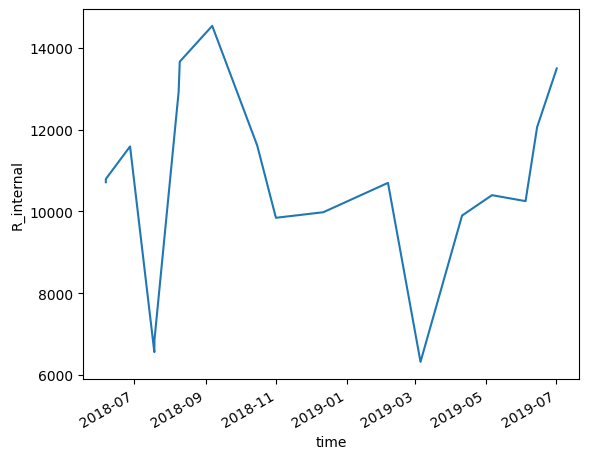

In [78]:
N2 = g/rho_ref *ds_gf10['dens'].differentiate('z')

N= np.sqrt(N2)
N = N.sel(time=slice('2018-06-01', '2019-07-01'))
N.name = 'N'
R_internal = (N.sum(dim='z')/ (f*np.pi))
R_internal.name = 'R_internal'
R_internal.plot()
# fig, ax = plt.subplots()
# pcol = R_internal.sel(z=slice(0,150), time=slice('2018-06-01', '2019-07-01')).plot(robust=False, yincrease=False, cmap='viridis', ax=ax, levels=[0, 100, 200, 500, 1000, 1500, 2000])
# # colorbar title
# pcol.colorbar.set_label(r'R$_{internal}$ [m]')
# # add monthly ticks
# ax.xaxis.set_major_locator(mdates.MonthLocator())
# plt.ylabel('Depth [m]')
# plt.xlabel('')



# VERTICAL HEAT FLUX

In [82]:
dfHeatFlux = pd.read_csv(file_vertical_heat_flux).rename(columns={"Unnamed: 0":"Depth (m)"})



In [83]:
fig = px.line(dfHeatFlux, y= "Depth (m)", x=dfHeatFlux.columns[1:])
fig.update_layout(yaxis_range=[550,200])


## dTdz

In [86]:
cond_stagnant = (df_gf10['datetime_first'] > pd.to_datetime('2018-07-01')) & (df_gf10['datetime_first'] < pd.to_datetime('2019-04-01'))
df_gf10_stagnant = df_gf10[cond_stagnant]
df_gf10_stagnant



,Unnamed: 0,index,Pressure [dbar],time,tv290C,c0S/m,flSP,par,sbox0Mm/Kg,seaTurbMtr,...,St.,date,Type,Name,YYYYMMDD,Distance,id,datedate,datetime,datetime_first
0,0,0,1.0,221.555727,4.0857,1.720515,0.300360,1.896100e+03,152.096,3.305,...,GF10,2018-08-09 13:20:14.812800,CTD,GF18090,20180809,94.0,GF18090,2018-08-09,2018-08-09 13:20:14.812800,2018-08-09 13:20:14.812800
1,1,1,2.0,221.555783,3.9921,1.847487,0.445550,1.196800e+03,152.170,3.148,...,GF10,2018-08-09 13:20:19.651200,CTD,GF18090,20180809,94.0,GF18090,2018-08-09,2018-08-09 13:20:19.651200,2018-08-09 13:20:14.812800
2,2,2,3.0,221.555813,3.2607,2.130664,1.105200,7.990600e+02,155.732,3.087,...,GF10,2018-08-09 13:20:22.243200,CTD,GF18090,20180809,94.0,GF18090,2018-08-09,2018-08-09 13:20:22.243200,2018-08-09 13:20:14.812800
3,3,3,4.0,221.555843,2.4344,2.309481,1.696600,5.185100e+02,157.771,2.845,...,GF10,2018-08-09 13:20:24.835200,CTD,GF18090,20180809,94.0,GF18090,2018-08-09,2018-08-09 13:20:24.835200,2018-08-09 13:20:14.812800
4,4,4,5.0,221.555870,1.3478,2.385462,2.619700,3.459900e+02,159.179,2.869,...,GF10,2018-08-09 13:20:27.168000,CTD,GF18090,20180809,94.0,GF18090,2018-08-09,2018-08-09 13:20:27.168000,2018-08-09 13:20:14.812800
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14044,6680,361,362.0,64.750745,2.1875,2.986155,0.059641,2.153700e-05,285.911,0.376,...,GF10,2019-03-05 18:01:04.368000,CTD,GF19017,20190305,94.0,GF19017,2019-03-05,2019-03-05 18:01:04.368000,2019-03-05 17:51:56.764800
14045,6681,362,363.0,64.750765,2.1876,2.986231,0.060033,2.002800e-05,285.919,0.314,...,GF10,2019-03-05 18:01:06.096000,CTD,GF19017,20190305,94.0,GF19017,2019-03-05,2019-03-05 18:01:06.096000,2019-03-05 17:51:56.764800
14046,6682,363,364.0,64.750779,2.1877,2.986279,0.061120,2.749900e-05,285.767,0.446,...,GF10,2019-03-05 18:01:07.305600,CTD,GF19017,20190305,94.0,GF19017,2019-03-05,2019-03-05 18:01:07.305600,2019-03-05 17:51:56.764800
14047,6683,364,365.0,64.750799,2.1877,2.986307,0.060793,6.123400e-07,285.686,0.408,...,GF10,2019-03-05 18:01:09.033600,CTD,GF19017,20190305,94.0,GF19017,2019-03-05,2019-03-05 18:01:09.033600,2019-03-05 17:51:56.764800


In [87]:

fig = px.line(df_gf10_stagnant, y='Pressure [dbar]', x='temp', color='YYYYMMDD', title='Temperature profiles between December 1 and April 1')
# invert ya axis
fig.update_layout(yaxis_autorange='reversed', width=800, height=800)




In [88]:
import pandas as pd
import plotly.express as px
import statsmodels.api as sm

# Assuming df_gf10_stagnant is your DataFrame
# Filter the data below 400 m
df_below_400m = df_gf10_stagnant[df_gf10_stagnant['Pressure [dbar]'] > 400]

# Perform linear regression for each date
regression_results = {}
for date in df_below_400m['YYYYMMDD'].unique():
    df_date = df_below_400m[df_below_400m['YYYYMMDD'] == date]
    X = df_date['Pressure [dbar]']
    y = df_date['temp']
    X = sm.add_constant(X)  # Add a constant term for the intercept
    model = sm.OLS(y, X).fit()
    regression_results[date] = model

# Create the plot
fig = px.line(df_gf10_stagnant, y='Pressure [dbar]', x='temp', color='YYYYMMDD', title='Temperature profiles between December 1 and April 1')

# Add the regression lines to the plot
for date, model in regression_results.items():
    df_date = df_below_400m[df_below_400m['YYYYMMDD'] == date]
    X = df_date['Pressure [dbar]']
    y_pred = model.predict(sm.add_constant(X))
    slope = model.params[1]  # Extract the slope (dT/dz)
    fig.add_scatter(x=y_pred, y=X, mode='lines', name=f'Regression {date} (dT/dz={slope:.4f})')

# Invert y-axis
fig.update_layout(yaxis_autorange='reversed', width=800, height=800)

# Show the plot
fig.show()

In [89]:
# calculate mean density for YYYYMMDD =- 20181211 below 400m
df_below_400m_20181211 = df_below_400m[df_below_400m['YYYYMMDD'] == 20181211]
mean_density_20181211 = df_below_400m_20181211['dens'].mean()
mean_density_20181211

1028.950009448819

In [90]:
spec_heat = 3850
Kz = 3.5e-5
dTdz = 0.0020
dens = mean_density_20181211

vertical_heat_flux =  dens*spec_heat*dTdz*Kz
vertical_heat_flux

0.2773020275464567

In [91]:
df_gf10.columns

Index(['Unnamed: 0', 'index', 'Pressure [dbar]', 'time', 'tv290C', 'c0S/m',
       'flSP', 'par', 'sbox0Mm/Kg', 'seaTurbMtr', 'scan', 'depSM', 'sal',
       'temp', 'sigma-dens', 'dens', 'svCM', 'flag', 'Latitude', 'Longitude',
       'St.', 'date', 'Type', 'Name', 'YYYYMMDD', 'Distance', 'id', 'datedate',
       'datetime', 'datetime_first'],
      dtype='object')